In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import path
import os
import pickle
from scipy.interpolate import griddata, interp1d
from scipy.stats import gaussian_kde, multivariate_normal
from interpolating_match import comb_harm_consistent

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Testing

## Setup

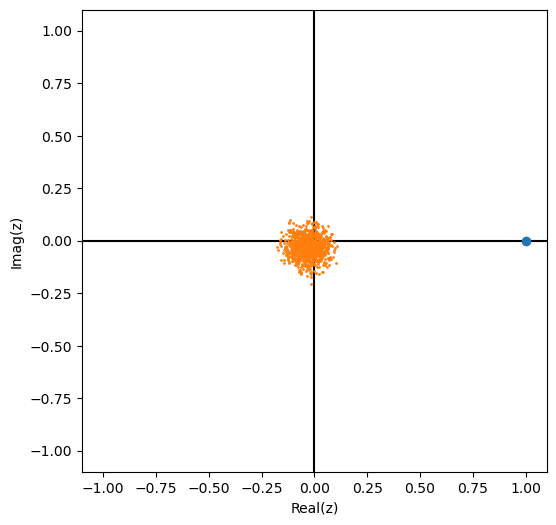

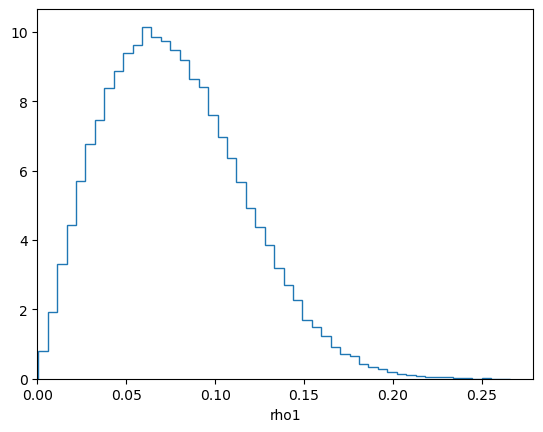

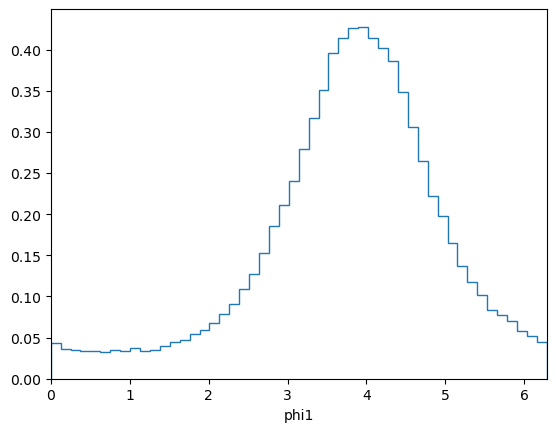

In [85]:
# SNRs and number of samples
rho_0 = 20
rho_1 = 1
rho_n1 = 1
z_0 = rho_0 + 1j*0
z_1 = -np.sqrt(rho_1**2/2)-1j*np.sqrt(rho_1**2/2)
z_n1 = -np.sqrt(rho_n1**2/2)-1j*np.sqrt(rho_n1**2/2)
n = 100000

# Generate samples
samples_real, samples_imag = np.random.normal(np.real(z_1), 1, n), np.random.normal(np.imag(z_1), 1, n)
samples = samples_real + 1j*samples_imag
samples_real_n1, samples_imag_n1 = np.random.normal(np.real(z_n1), 1, n), np.random.normal(np.imag(z_n1), 1, n)
samples_n1 = samples_real_n1 + 1j*samples_imag_n1

# Plot samples in complex space
plt.figure(figsize=(6,6))
plt.scatter(np.real(z_0)/np.abs(z_0), np.imag(z_0)/np.abs(z_0))
plt.scatter(samples_real[::100]/np.abs(z_0), samples_imag[::100]/np.abs(z_0), s=1)
max_point = np.max([np.max([samples_real/np.abs(z_0), samples_imag/np.abs(z_0)]), np.real(z_0)/np.abs(z_0), np.imag(z_0)/np.abs(z_0)])*1.1
plt.xlim(-max_point,max_point)
plt.ylim(-max_point,max_point)
plt.axvline(0, c='k', zorder=0)
plt.axhline(0, c='k', zorder=0)
plt.xlabel('Real(z)')
plt.ylabel('Imag(z)')
plt.show()

# Plot amplitude of samples (SNR)
plt.hist(np.abs(samples)/np.abs(z_0), bins=50, histtype='step', density=True)
plt.xlim(0,)
plt.xlabel('rho1')
plt.show()

# Plot phase of samples
plt.hist(np.angle(samples)%(2*np.pi), bins=50, histtype='step', range=(0,2*np.pi), density=True)
plt.xlim(0,2*np.pi)
plt.xlabel('phi1')
plt.show()

## Prior mapping back and forth

In [3]:
with open(os.path.join('grid_data_4d', 'dataslot_0', 'all_matches'), 'rb') as fp:
    grid_data_0 = pickle.load(fp)

In [4]:
# Get sparse mapping points
e_vals = grid_data_0['metadata']['degen_params']['ecc10']
MA_vals = grid_data_0['metadata']['MA_vals']
sparse_e = np.tile(np.repeat(e_vals, len(MA_vals)),3)
MA_merger = (grid_data_0['h1_phase']-grid_data_0['h0_phase']).flatten()%(2*np.pi)
sparse_MA = np.concatenate((MA_merger-2*np.pi, MA_merger, MA_merger+2*np.pi))
sparse_SNR = np.tile(grid_data_0['h1_h0'].flatten(), 3)

# Get dense mapping points
map_len = 151
map_MA = np.repeat(np.linspace(0, 2*np.pi, map_len), map_len)
map_e = np.tile(np.linspace(np.min(e_vals), np.max(e_vals), map_len), map_len)
map_SNR = griddata((sparse_e, sparse_MA), sparse_SNR, (map_e, map_MA), method='linear')

In [74]:
# Draw prior
n_prior = 10**5
ecc_prior = np.random.rand(n_prior)*(np.max(e_vals)-np.min(e_vals)) + np.min(e_vals)
MA_prior= np.random.rand(n_prior)*2*np.pi

In [75]:
# Put prior through inverse map
prior_rho_frac = griddata((map_e, map_MA), map_SNR, (ecc_prior, MA_prior), method='linear')
prior_samples = prior_rho_frac*np.e**(1j*MA_prior)

Text(0, 0.5, 'Imag(z_prior)')

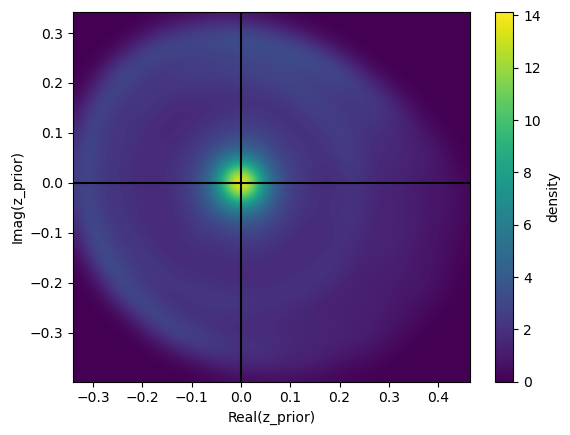

In [7]:
# Compute prior kde at points on 2d grid
kde_samples = np.array([np.real(prior_samples), np.imag(prior_samples)])
kernel = gaussian_kde(kde_samples)
kde_x, kde_y = np.mgrid[np.min(np.real(prior_samples)):np.max(np.real(prior_samples)):51j, np.min(np.imag(prior_samples)):np.max(np.imag(prior_samples)):51j]
kde_z = kernel(np.vstack([kde_x.flatten(), kde_y.flatten()])).reshape(kde_x.shape)

# Plot prior kde
x_coords = kde_x[:,0]
y_coords = kde_y[0]
dx = (x_coords[1]-x_coords[0])/2.
dy = (y_coords[1]-y_coords[0])/2.
extent = [x_coords[0]-dx, x_coords[-1]+dx, y_coords[0]-dy, y_coords[-1]+dy]
cm = plt.imshow(kde_z.T, interpolation='bicubic', cmap='viridis', extent=extent, origin='lower', aspect='auto')
plt.colorbar(cm, label='density')

# Plot formatting
plt.axvline(0, c='k')
plt.axhline(0, c='k')
plt.xlabel('Real(z_prior)')
plt.ylabel('Imag(z_prior)')

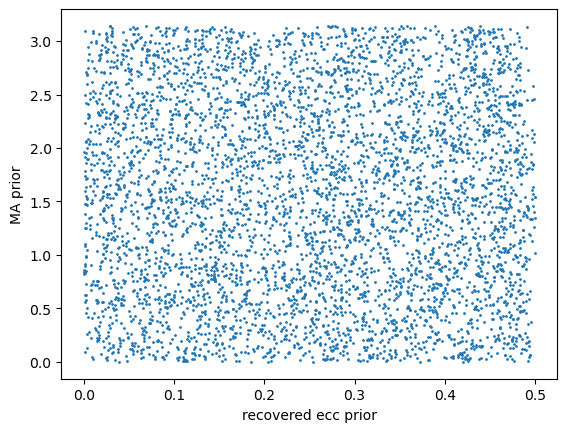

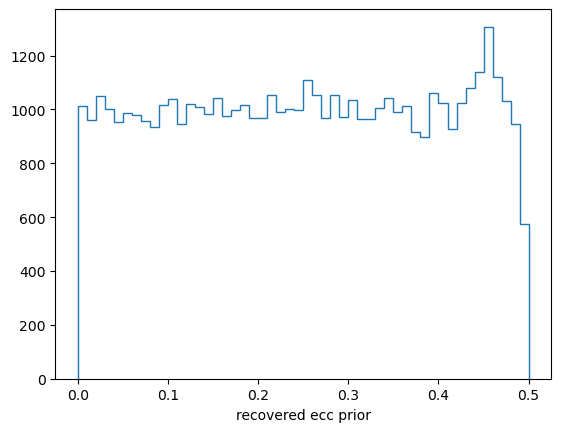

In [9]:
# Mapping back to ecc/MA space to check recover original flat priors
reverse_ecc_prior = griddata((map_SNR, map_MA), map_e, (np.abs(prior_samples), np.angle(prior_samples)), method='linear')

plt.scatter(reverse_ecc_prior[::10], MA_prior[::10], s=1)
plt.xlabel('recovered ecc prior')
plt.ylabel('MA prior')
plt.show()

plt.hist(reverse_ecc_prior, histtype='step', bins=50, range=(0,0.5))
plt.xlabel('recovered ecc prior')
plt.show()

# Prior rejection sampling

First let's see if we can use the kde of the prior to draw weights for samples on SNR. This would give better sampling efficiency than vice versa. We can test this by drawing samples from the kde and seeing if it maps to the correct original ecc/MA prior as the actual prior samples should.

121250 1002001 0.12100786326560552


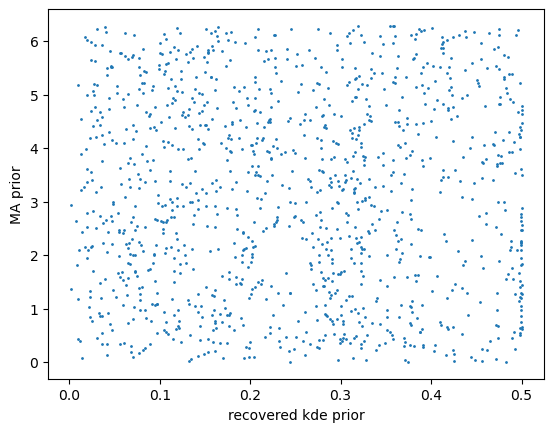

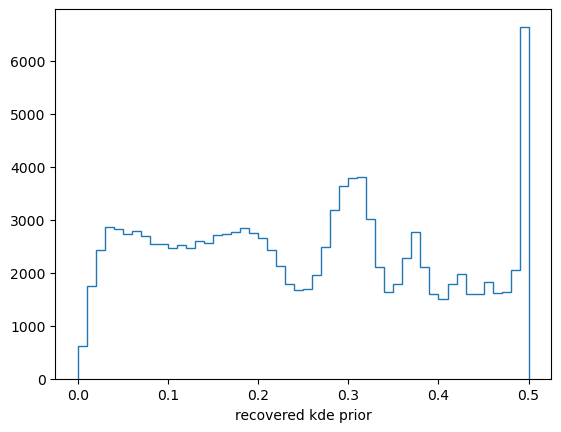

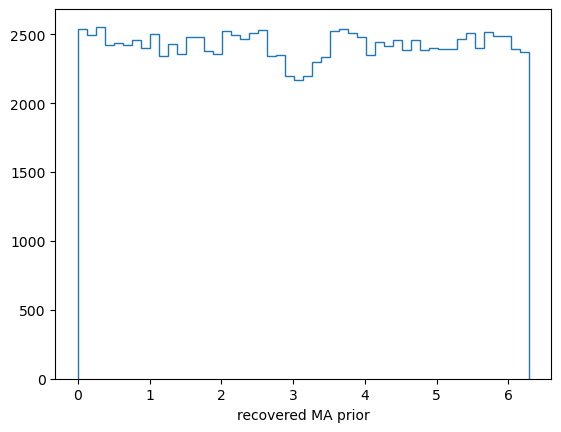

In [12]:
# Construct kde
kde_samples = np.array([np.real(prior_samples), np.imag(prior_samples)])
kernel = gaussian_kde(kde_samples)
kde_x, kde_y = np.mgrid[np.min(np.real(prior_samples)):np.max(np.real(prior_samples)):51j, np.min(np.imag(prior_samples)):np.max(np.imag(prior_samples)):51j]
kde_z = kernel(np.vstack([kde_x.flatten(), kde_y.flatten()])).reshape(kde_x.shape)

# Get samples from kde
prior_rej_x, prior_rej_y = np.mgrid[np.min(np.real(prior_samples)):np.max(np.real(prior_samples)):1001j, np.min(np.imag(prior_samples)):np.max(np.imag(prior_samples)):1001j]
weights = griddata((kde_x.flatten(), kde_y.flatten()), kde_z.flatten(), (prior_rej_x.flatten(), prior_rej_y.flatten()), method='linear')
prior_rej = prior_rej_x.flatten()+1j*prior_rej_y.flatten()
weights /= np.max(weights)
prior_kde_approx = prior_rej[np.random.rand(len(weights))<=weights]
print(len(prior_kde_approx), len(weights), len(prior_kde_approx)/len(weights))

# Map back to e/MA to test how accuracy of kde of prior
reverse_kde_prior = griddata((map_SNR, map_MA), map_e, (np.abs(prior_kde_approx), np.angle(prior_kde_approx)%(2*np.pi)), method='linear')
plt.scatter(reverse_kde_prior[::100], np.angle(prior_kde_approx[::100])%(2*np.pi), s=1)
plt.xlabel('recovered kde prior')
plt.ylabel('MA prior')
plt.show()
plt.hist(reverse_kde_prior, histtype='step', bins=50, range=(0,0.5))
plt.xlabel('recovered kde prior')
plt.show()
plt.hist(np.angle(prior_kde_approx)%(2*np.pi), histtype='step', bins=50, range=(0,2*np.pi))
plt.xlabel('recovered MA prior')
plt.show()

This is not very accurate, especially for eccentricity, and we do not find sufficient improvement from adjusting the bw_factor when building the kde.

Next up is to try the other way around - rejecting the prior samples based on weights from the analytic 2d gaussian on SNR.

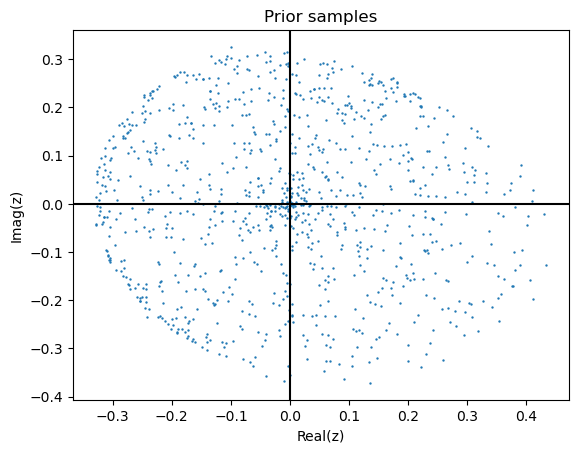

3100 100000 0.031


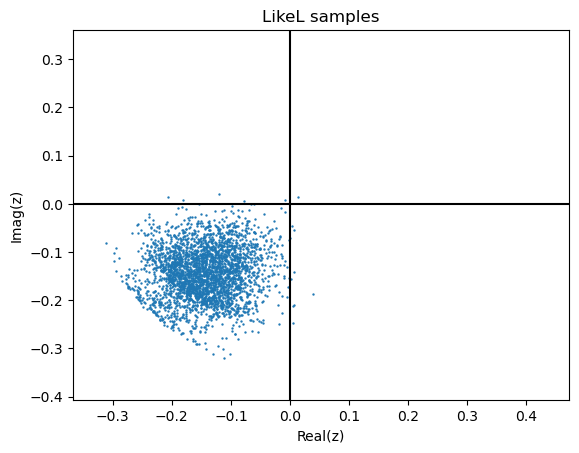

In [76]:
# Plot prior samples
plt.scatter(np.real(prior_samples[::100]), np.imag(prior_samples[::100]), s=0.5)
plt.axvline(0, c='k')
plt.axhline(0, c='k')
plt.xlabel('Real(z)')
plt.ylabel('Imag(z)')
plt.title('Prior samples')
xlims = plt.gca().get_xlim()
ylims = plt.gca().get_ylim()
plt.show()

# Analytic 2d gaussian to model h1 SNR
rv = multivariate_normal(mean=[np.real(z_1), np.imag(z_1)], cov=[1,1])

# Get weights for each prior sample
weights = rv.pdf(np.array([np.real(prior_samples)*np.abs(z_0), np.imag(prior_samples)*np.abs(z_0)]).T)
weights /= np.max(weights)
likeL_samples = prior_samples[np.random.rand(len(weights))<=weights]

# Print sampling efficiency and plot resulting likeL samples
print(len(likeL_samples), len(prior_samples), len(likeL_samples)/len(prior_samples))
plt.scatter(np.real(likeL_samples), np.imag(likeL_samples), s=0.5)
plt.axvline(0, c='k')
plt.axhline(0, c='k')
plt.xlabel('Real(z)')
plt.ylabel('Imag(z)')
plt.title('LikeL samples')
plt.xlim(xlims)
plt.ylim(ylims)
plt.show()

Converting entire prior from ecc/MA to complex SNR, then rejection sampling this based on the pdf of the 2d gaussian as weights will give very poor sampling efficiency as the vast majority of the prior samples will be far away from this 2d gaussian.

What if we instead try to only generate ecc/MA prior samples in the region that corresponds to the 2d gaussian we are interested in - this should give much better sampling efficiency. To do this, let's get a ring corresponding to constant pdf value (for now let's do 10**-3 times the peak pdf value) and map this to ecc/MA space to set the bounds of the grid.

$$
f(x,y) = \frac{1}{2\pi} e^{-\frac{1}{2}(x-a)^2} e^{-\frac{1}{2}(y-b)^2} = g,
$$

$$
\ln{\frac{1}{2\pi}} - \frac{1}{2}\left[(x-a)^2 + (y-b)^2\right] = \ln{g},
$$

$$
(x-a)^2 + (y-b)^2 = -2\ln{2\pi g},
$$

where $g$ is the target pdf value. The peak value is obtained by setting $x=a$ and $y=b$, meaning

$$
(x-a)^2 + (y-b)^2 = -2\ln{p},
$$

where $p$ is the fraction of the peak we are aiming for.

This is therefore a circle centred at $(a,b)$ with radius $\sqrt{-2\ln{p}}$.

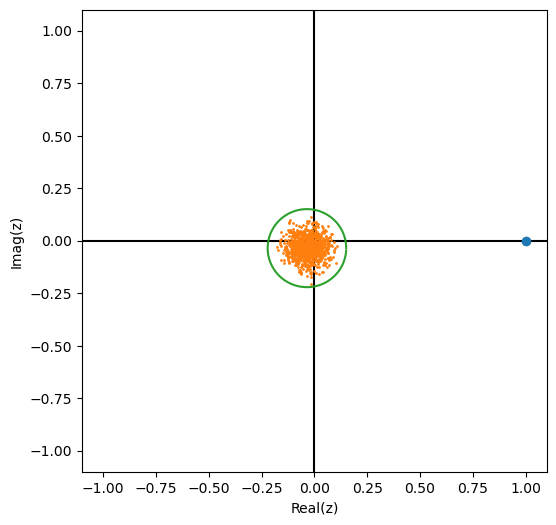

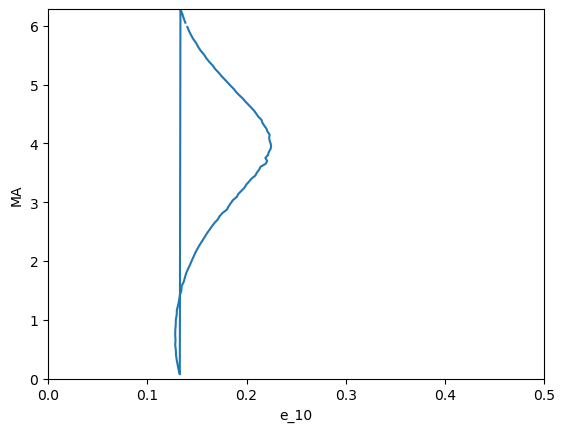

In [86]:
# Generate ring
n_pts = 100
p = 10**-3
theta_pts = np.linspace(0, 2*np.pi, n_pts, endpoint=False)
SNR_prior_ring = np.sqrt(-2*np.log(p))*np.cos(theta_pts) + 1j*np.sqrt(-2*np.log(p))*np.sin(theta_pts) + (z_1)
SNR_prior_ring /= np.abs(z_0)

# Plot samples and ring in complex space
plt.figure(figsize=(6,6))
plt.scatter(np.real(z_0)/np.abs(z_0), np.imag(z_0)/np.abs(z_0))
plt.scatter(samples_real[::100]/np.abs(z_0), samples_imag[::100]/np.abs(z_0), s=1)
plt.plot(np.real(SNR_prior_ring), np.imag(SNR_prior_ring), c='C2')
max_point = np.max([np.max([samples_real/np.abs(z_0), samples_imag/np.abs(z_0)]), np.real(z_0)/np.abs(z_0), np.imag(z_0)/np.abs(z_0)])*1.1
plt.xlim(-max_point,max_point)
plt.ylim(-max_point,max_point)
plt.axvline(0, c='k', zorder=0)
plt.axhline(0, c='k', zorder=0)
plt.xlabel('Real(z)')
plt.ylabel('Imag(z)')
plt.show()

# Convert ring to ecc/MA and plot
ecc_prior_ring = griddata((map_SNR, map_MA), map_e, (np.abs(SNR_prior_ring), np.angle(SNR_prior_ring)%(2*np.pi)), method='linear')
plt.plot(ecc_prior_ring, np.angle(SNR_prior_ring)%(2*np.pi))
plt.xlim(0,0.5)
plt.ylim(0,2*np.pi)
plt.xlabel('e_10')
plt.ylabel('MA')
plt.show()

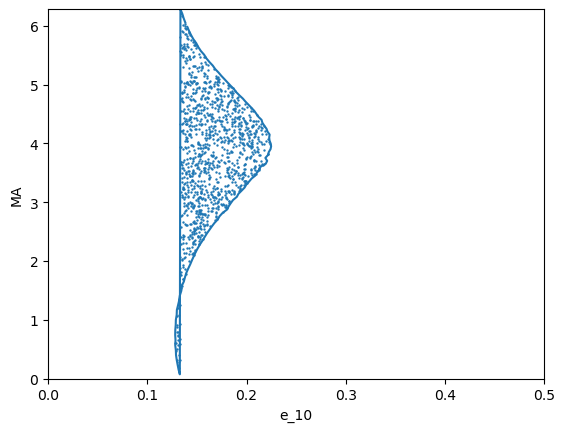

14037 118091 0.11886595930257174


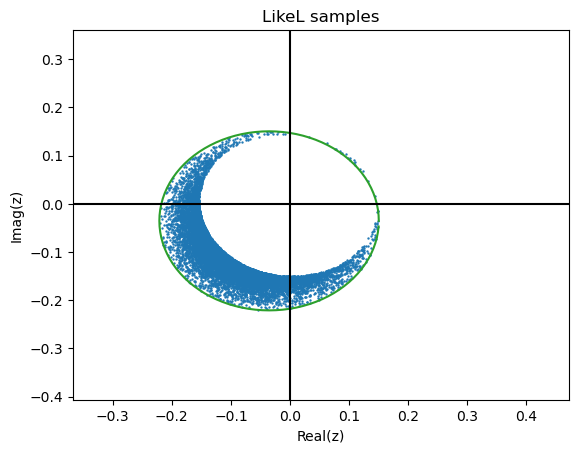

In [87]:
# Test how many in ring to work out how many total points to make
n_mgrid = 20
ecc_test, MA_test = np.mgrid[np.min(e_vals):np.max(e_vals):n_mgrid*1j, 0:2*np.pi*(n_mgrid-1)/n_mgrid:n_mgrid*1j]
ecc_MA_path = path.Path(np.array([ecc_prior_ring, np.angle(SNR_prior_ring)%(2*np.pi)]).T)
n_in_ring = np.sum(ecc_MA_path.contains_points(np.array([ecc_test.flatten(), MA_test.flatten()]).T))
n_prior_total = int(n_mgrid**2*n_prior/n_in_ring)

# Create new total prior and cut those outside ring
ecc_prior_large = np.random.rand(n_prior_total)*(np.max(e_vals)-np.min(e_vals)) + np.min(e_vals)
MA_prior_large = np.random.rand(n_prior_total)*2*np.pi
inside_ring = ecc_MA_path.contains_points(np.array([ecc_prior_large, MA_prior_large]).T)
ecc_prior_small = ecc_prior_large[inside_ring]
MA_prior_small = MA_prior_large[inside_ring]

# Find points inside ring
plt.plot(ecc_prior_ring, np.angle(SNR_prior_ring)%(2*np.pi))
plt.scatter(ecc_prior_small[::100], MA_prior_small[::100], s=0.5)
plt.xlim(0,0.5)
plt.ylim(0,2*np.pi)
plt.xlabel('e_10')
plt.ylabel('MA')
plt.show()

# Map points back to SNR and perform rejection sampling
abs_SNR_prior_small = griddata((map_e, map_MA), map_SNR, (ecc_prior_small, MA_prior_small), method='linear')
SNR_prior_small = abs_SNR_prior_small*np.exp(1j*MA_prior_small)
rv = multivariate_normal(mean=[np.real(z_1), np.imag(z_1)], cov=[1,1])
weights = rv.pdf(np.array([np.real(SNR_prior_small)*np.abs(z_0), np.imag(SNR_prior_small)*np.abs(z_0)]).T)
weights /= np.max(weights)
SNR_likeL = SNR_prior_small[np.random.rand(len(weights))<=weights]

# Print sampling efficiency and plot resulting likeL samples
print(len(SNR_likeL), len(SNR_prior_small), len(SNR_likeL)/len(SNR_prior_small))
plt.scatter(np.real(SNR_likeL), np.imag(SNR_likeL), s=0.5)
plt.plot(np.real(SNR_prior_ring), np.imag(SNR_prior_ring), c='C2')
plt.axvline(0, c='k')
plt.axhline(0, c='k')
plt.xlabel('Real(z)')
plt.ylabel('Imag(z)')
plt.title('LikeL samples')
plt.xlim(xlims)
plt.ylim(ylims)
plt.show()

LikeL samples distribution looks the same as before but with a factor ~4 better sample efficiency in this example. Crucially the end number of samples should be much more resilient against different SNR values. 

This approach currently fails however when the ring includes SNR = 0, or if MA goes between the 0/2*np.pi line. Additionally, low ecc samples may be lost if log uniform prior on ecc is used. Finally, it is not clear whether this would be easily applicable to h1,h-1 combination. First two points are easily solvable but others would require more thinking.

Overall added complexity probably not worth it compared to just drawing more prior samples and dealing with poor sampling efficiency.

## Map to eccentricity

In [246]:
np.quantile(ecc, [0.1,0.5,0.9])

array([0.09499384, 0.16770124, 0.26447185])

Text(0.5, 0, 'e_10')

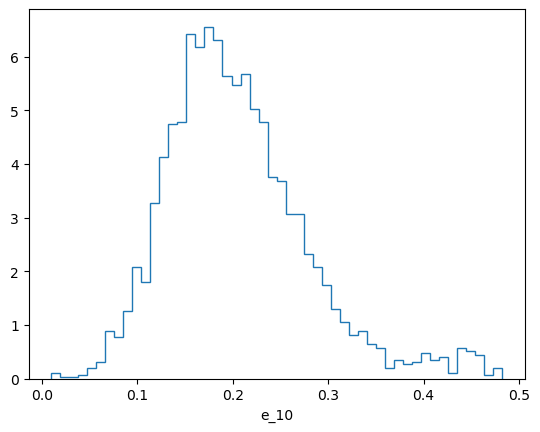

In [77]:
ecc = griddata((map_SNR, map_MA), map_e, (np.abs(likeL_samples), np.angle(likeL_samples)%(2*np.pi)), method='linear')
plt.hist(ecc, histtype='step', bins=50, density=True)
plt.xlabel('e_10')

Text(0.5, 0, 'e_10')

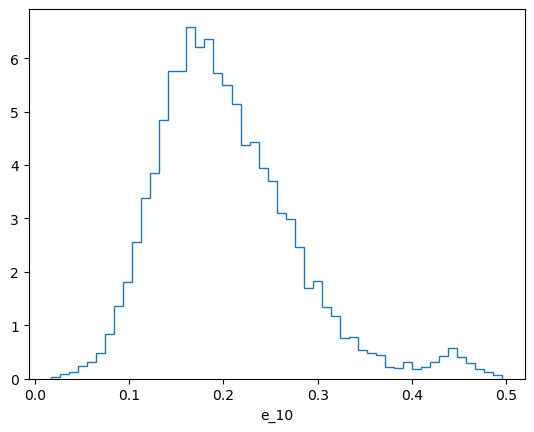

In [84]:
ecc = griddata((map_SNR, map_MA), map_e, (np.abs(SNR_likeL), np.angle(SNR_likeL)%(2*np.pi)), method='linear')
plt.hist(ecc, histtype='step', bins=50, density=True)
plt.xlabel('e_10')

Text(0.5, 0, 'e_10')

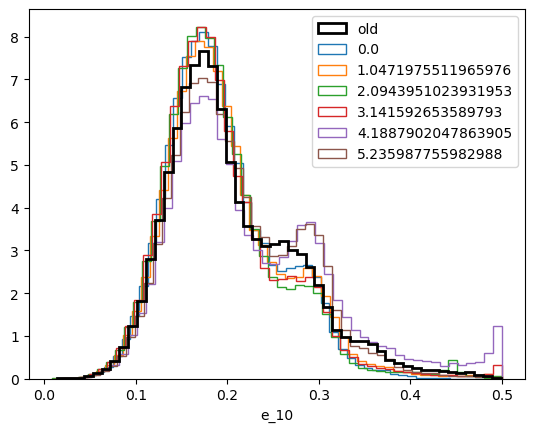

In [178]:
# Setup map
e_vals = grid_data_0['metadata']['degen_params']['ecc10']
MA_vals = grid_data_0['metadata']['MA_vals']
MA_merger = (grid_data_0['h1_phase']-grid_data_0['h0_phase']).flatten()%(2*np.pi)
SNR_tile = np.tile(grid_data_0['h1_h0'].flatten(), 3)
SNR_MA_points = (SNR_tile, np.concatenate((MA_merger-2*np.pi, MA_merger, MA_merger+2*np.pi)))
e_tile = np.tile(np.repeat(e_vals, len(MA_vals)),3)

# Rough approx of phase-agnostic method, does not flip nc or enforce prior
max_interp = interp1d(np.max(grid_data_0['h1_h0'], axis=1), e_vals, bounds_error=False)
min_interp = interp1d(np.min(grid_data_0['h1_h0'], axis=1), e_vals, bounds_error=False)
max_vals = max_interp(np.abs(samples)/np.abs(z_0))
min_vals = min_interp(np.abs(samples)/np.abs(z_0))
old_ecc = np.random.rand(len(max_vals))*(min_vals-max_vals)+max_vals
plt.hist(old_ecc, histtype='step', bins=50, label='old', density=True, color='k', lw=2, zorder=5)

# Plot for six different phase values
ecc_list = []
for MA in np.linspace(0, 2*np.pi, 6, endpoint=False):
    input_samples = (np.abs(samples)/np.abs(z_0), (np.angle(samples)-MA)%(2*np.pi))
    ecc = griddata(SNR_MA_points, e_tile, input_samples, method='linear')
    ecc[np.isnan(ecc)] = np.max(e_vals)
    ecc_list.append(ecc)
    plt.hist(ecc, histtype='step', bins=50, label=str(MA), density=True)
plt.legend()
plt.xlabel('e_10')

## Interesting plots

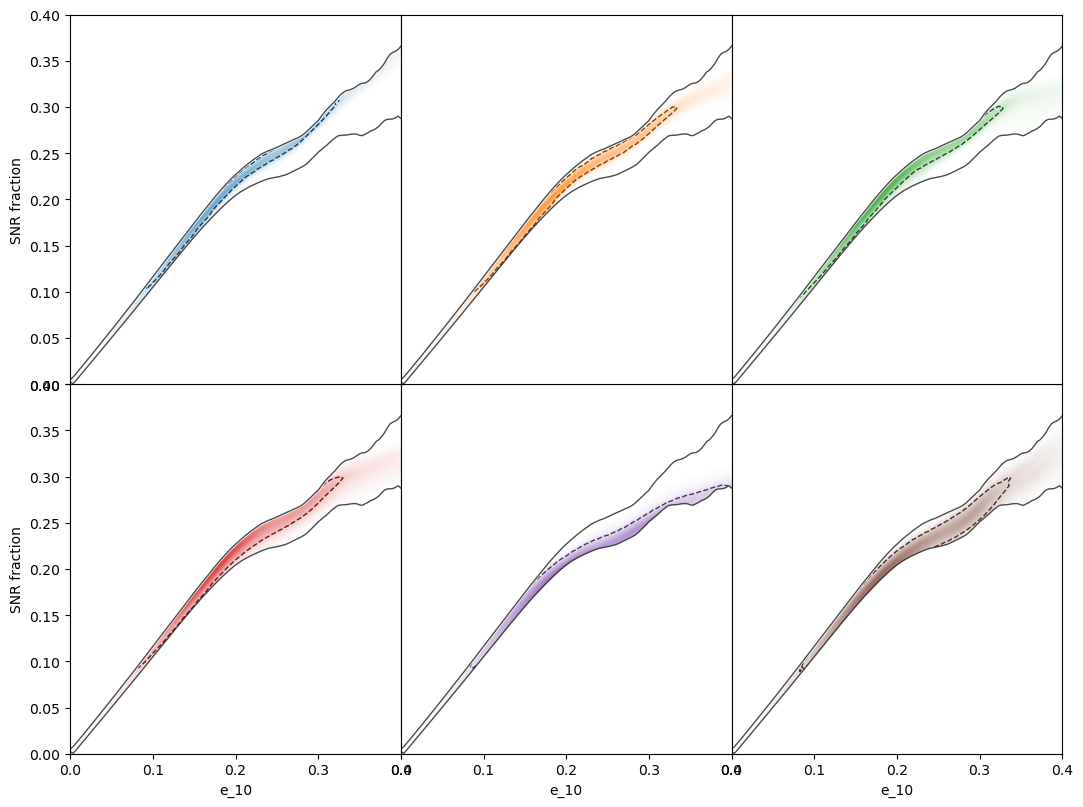

In [32]:
plt.figure(figsize=(6.4*2,4.8*2))
axs = [None]
s_xs = [1, 2, 3, 0, 0, 0]
s_ys = [0, 4, 4, 0, 1, 1]
for i in [3,4,5,0,1,2]:

    # Move onto next subplot
    plt.subplot(2,3,i+1, sharex=axs[s_xs[i]], sharey=axs[s_ys[i]])
    axs.append(plt.gca())

    # Compute kde at points on 2d grid
    kde_samples = np.array([ecc_list[i], np.abs(samples)/np.abs(z_0)])
    kernel = gaussian_kde(kde_samples)
    kde_x, kde_y = np.mgrid[np.min(ecc_list[i]):np.max(ecc_list[i]):101j, np.min(np.abs(samples)/np.abs(z_0)):np.max(np.abs(samples)/np.abs(z_0)):101j]
    max_interp = interp1d(e_vals, np.max(grid_data_0['h1_h0'], axis=1))
    min_interp = interp1d(e_vals, np.min(grid_data_0['h1_h0'], axis=1))
    inside_lines = (kde_y.flatten() <= max_interp(kde_x.flatten())*1.1)*(kde_y.flatten() >= min_interp(kde_x.flatten())*0.9)
    kde_z = np.zeros(len(kde_x.flatten()))
    kde_z[inside_lines] = kernel(np.vstack([kde_x.flatten()[inside_lines], kde_y.flatten()[inside_lines]]))
    kde_z = kde_z.reshape(kde_x.shape)
    
    # Calculate contour levels for different confidence intervals
    t = np.linspace(0, np.max(kde_z), 1000)
    integral = ((kde_z >= t[:, None, None]) * kde_z).sum(axis=(1,2))
    integral /= np.max(integral)
    f = interp1d(integral, t)
    t_contours = f([0.9])
    
    # Calculate color map with varying alpha
    c_rgba = mcolors.to_rgba(f'C{i}')
    cmap_rgbas = [c_rgba[:3]+(alpha,) for alpha in np.linspace(0,1,101)]
    cmap = mcolors.ListedColormap(cmap_rgbas)
    
    # Plot density and 90% contour
    x_coords = kde_x[:,0]
    y_coords = kde_y[0]
    dx = (x_coords[1]-x_coords[0])/2.
    dy = (y_coords[1]-y_coords[0])/2.
    extent = [x_coords[0]-dx, x_coords[-1]+dx, y_coords[0]-dy, y_coords[-1]+dy]
    plt.imshow(np.sqrt(kde_z.T), interpolation='bicubic', cmap=cmap, extent=extent, origin='lower', aspect='auto',zorder=1/4)
    contour_c = tuple(p*0.5 for p in c_rgba[:3]) +  (c_rgba[3],)
    plt.contour(kde_x, kde_y, kde_z, levels=t_contours, colors=[contour_c], linewidths=1, linestyles='dashed', zorder=2/4)
    
    # Plot min/max lines
    plt.fill_between(e_vals, np.min(grid_data_0['h1_h0']), np.min(grid_data_0['h1_h0'], axis=1), color='w', zorder=3/4)
    plt.fill_between(e_vals, np.max(grid_data_0['h1_h0'], axis=1), np.max(grid_data_0['h1_h0']), color='w', zorder=3/4)
    plt.plot(e_vals, np.max(grid_data_0['h1_h0'], axis=1), c='k', lw=1, alpha=0.7, zorder=4/4)
    plt.plot(e_vals, np.min(grid_data_0['h1_h0'], axis=1), c='k', lw=1, alpha=0.7, zorder=4/4)
    
    # Plot formatting
    if axs[s_xs[i]] is None:
        plt.xlabel('e_10')
        plt.xlim(0,0.4)
    else:
        plt.gca().axes.get_xaxis().set_visible(False)
    if axs[s_ys[i]] is None:
        plt.ylabel('SNR fraction')
        plt.ylim(0,0.4)
    else:
        plt.gca().axes.get_yaxis().set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

(0.0, 1.0)

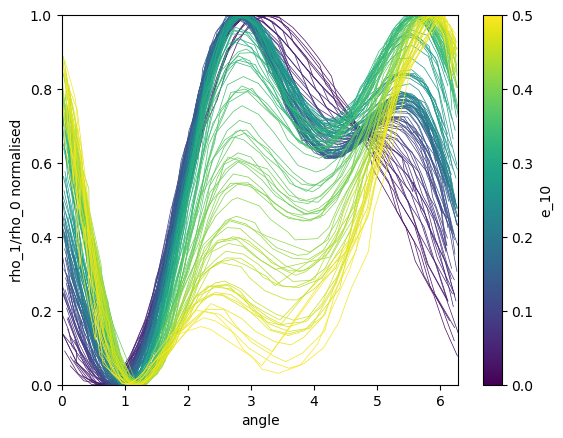

In [260]:
# Plot for each constant eccentricity
cmap = plt.cm.viridis(np.linspace(0,1,len(e_vals)))
for i in range(len(e_vals)):
    if i>5:
        x = (grid_data_0['h1_phase']-grid_data_0['h0_phase'])[i]%(2*np.pi)
        y = grid_data_0['h1_h0'][i]
        x, y = zip(*sorted(zip(x, y)))
        min_y = np.min(y)
        max_y = np.max(y)
        y = (y-min_y)/(max_y-min_y)
        plt.plot(x, y, c=cmap[i], lw=0.5)

# Fake colorbar
colors = np.linspace(np.min(e_vals),np.max(e_vals),len(e_vals))
mappable = plt.scatter([10]*len(e_vals), [10]*len(e_vals), s=1, c=colors, cmap='viridis')
plt.colorbar(mappable, label='e_10')

# Plot formatting
plt.xlabel('angle')
plt.ylabel('rho_1/rho_0 normalised')
plt.xlim(0,2*np.pi)
plt.ylim(0,1)

## Test h1 and h-1

Initial phase of harmonics in signal is 

$$
\Phi_k = 2 \gamma_\mathrm{ref} + (2+k)l_\mathrm{ref},
$$

so 

$$
\Phi_1 - \Phi_0 = \Phi_0 - \Phi_{-1} = l_\mathrm{ref}.
$$

The SNR/likelihood is given by

$$
\frac{1}{2}\rho^2 = \log \Lambda = \sum_{k\in [-1,1]} \alpha_k A_k \cos\left(\Phi_k-\varphi_k\right)-\frac{1}{2}A_k^2,
$$

where $\alpha, \varphi$ are measured values, and $A, \Phi$ are true values we want to optimise over (other than $\Phi_0$ which we assume to be known).

Enforcing phase consistency we get

$$
\log \Lambda = \sum_{k\in [-1,1]} \alpha_k A_k \cos\left(kl_\mathrm{ref}+\left(\Phi_0-\varphi_k\right)\right)-\frac{1}{2}A_k^2,
$$

now optimising over $A_1$, $A_{-1}$, and $l_\mathrm{ref}$.

Maximising the amplitudes first gives us

$$
A_k = \alpha_k \cos(kl_\mathrm{ref} + (\Phi_0 - \varphi_k)),
$$

$$
\log{\Lambda}  = \sum_{k \in [-1, 1]} \frac{\alpha_k^{2}}{4} 
\left[ 1  + \cos 2 l_\mathrm{ref} \cos(2 (\Phi_{0} - \varphi_k)) - k \sin 2 l_\mathrm{ref} \sin(2 (\Phi_{0} - \varphi_k)) \right],
$$

so all that remains is to optimise over $l_\mathrm{ref}$.

$$
\frac{d\log \Lambda}{dl_\mathrm{ref}} = \sum_{k \in [-1, 1]} \frac{\alpha_k^{2}}{4} 
\left[ - 2 \sin 2 l_\mathrm{ref} \cos(2 (\Phi_{0} - \varphi_k)) - 2 k \cos 2 l_\mathrm{ref} \sin(2 (\Phi_{0} - \varphi_k)) \right] = 0,
$$

$$
\tan{2l_\mathrm{ref}} = \frac{\alpha_{-1}^2\sin(2 (\Phi_{0} - \varphi_{-1})) - \alpha_1^2\sin(2 (\Phi_{0} - \varphi_1))}{\alpha_1^2\cos(2 (\Phi_{0} - \varphi_1)) + \alpha_{-1}^2\cos(2 (\Phi_{0} - \varphi_{-1}))}.
$$

Note if $\left(\Phi_0 - \varphi_1\right) = - \left(\Phi_0 - \varphi_{-1}\right)$, this becomes $l_\mathrm{ref} = - \left(\Phi_0 - \varphi_1\right) = \left(\Phi_0 - \varphi_{-1}\right)$ as expected.

Due to the argument of $2l_\mathrm{ref}$, there will be two solutions for $l_\mathrm{ref}$ between $0$ and $2\pi$, so we must somehow choose the correct one. We can use the equations we obtained for $A_k$ above for this, which must be positive. One of the solutions is guaranteed to give both amplitudes positive if $|2\Phi_{0} - (\varphi_{1} + \varphi_{-1})| \leq \pi/2$, which is the case we are interested in here, so we can use this to select the correct solution.

Substituting back we get 

$$
\log{\Lambda} = \frac{1}{4}\left[ \alpha_{1}^{2} + \alpha_{-1}^{2} + 
\sqrt{\alpha_{1}^{4} + 2 \alpha_{1}^{2} \alpha_{-1}^{2} \cos[4\Phi_{0} - 2(\varphi_{1} + \varphi_{-1})] + \alpha_{-1}^4} \right].
$$

This gives the amplitude of the SNR, whilst we can use the equation for $\tan 2l_\mathrm{ref}$ to get the phase.

If h1 and h-1 are more than 90 degrees out of phase, i.e. $|2\Phi_{0} - (\varphi_{1} + \varphi_{-1})| \geq \pi/2$, we should instead use

$$
\log \Lambda = \frac{1}{2}\mathrm{Max}\left(\alpha_1^2, \alpha_{-1}^2\right),
$$

for the amplitude, and take the corresponding measurement of $l_\mathrm{ref}$.

(0.0, 6.283185307179586)

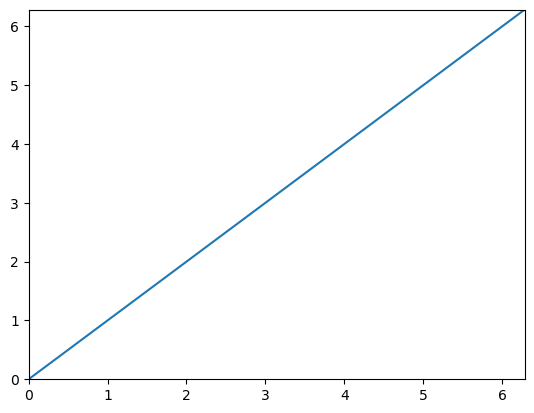

In [52]:
# Test params
a = np.linspace(0, 2*np.pi, 1001)
alpha_1 = 2
alpha_n1 = 2
phi_0 = np.pi
phi_1 = np.pi + a
phi_n1 = np.pi - a

# Calculate MA assuming within 90 degrees (otherwise trivial)
sin_num = alpha_n1*np.sin(2*(phi_0-phi_n1)) - alpha_1*np.sin(2*(phi_0 - phi_1))
cos_denom = alpha_1*np.cos(2*(phi_0-phi_1)) + alpha_n1*np.cos(2*(phi_0 - phi_n1))
MAs = []
for sin_n, cos_d, phi_1_ in zip(sin_num, cos_denom, phi_1):
    MA = np.arctan2(sin_n, cos_d)/2
    if np.cos(MA + phi_0 - phi_1_) < 0:
        MA += np.pi
    MA = MA%(2*np.pi)
    MAs.append(MA)
plt.plot(a, MAs, c='C0')
plt.xlim(0,2*np.pi)
plt.ylim(0,2*np.pi)

In [2]:
# Test params
alpha_1 = 5
alpha_n1 = 2
phi_0 = np.pi
phi_1 = np.pi + np.pi
phi_n1 = np.pi - 2*np.pi/3

# Check in valid regime
angle_arg = 2*phi_0-phi_1-phi_n1
condition = np.abs(angle_arg - np.round(angle_arg/(2*np.pi),0)*2*np.pi) <= np.pi/2
if condition:
    print('valid')
else:
    print('invalid')

# Calculate MA assuming within 90 degrees (otherwise trivial)
sin_num = alpha_n1**2*np.sin(2*(phi_0-phi_n1)) - alpha_1**2*np.sin(2*(phi_0 - phi_1))
cos_denom = alpha_1**2*np.cos(2*(phi_0-phi_1)) + alpha_n1**2*np.cos(2*(phi_0 - phi_n1))
MA = np.arctan2(sin_num, cos_denom)/2
if np.cos(MA + phi_0 - phi_1) < 0:
    MA += np.pi
MA = MA%(2*np.pi)
print(MA)

valid
3.066847895683503


In [2]:
# Test params
alpha_0 = 20
alpha_1 = 5
alpha_n1 = 2
phi_0 = np.pi
phi_1 = np.pi + 1
phi_n1 = np.pi -0.5

# Check in valid regime
angle_arg = 2*phi_0-phi_1-phi_n1
condition = np.abs(angle_arg - np.round(angle_arg/(2*np.pi),0)*2*np.pi) <= np.pi/2
if condition:
    print('valid')
else:
    print('invalid')

SNR_frac, MA = comb_harm_consistent([[alpha_0, alpha_0], [alpha_1, alpha_1], [alpha_n1, alpha_n1]], [[phi_0, phi_0], [phi_1, phi_1], [phi_n1, phi_n1]])
print(SNR_frac, MA)

valid
[0.26544531 0.26544531] [0.93835305 0.93835305]


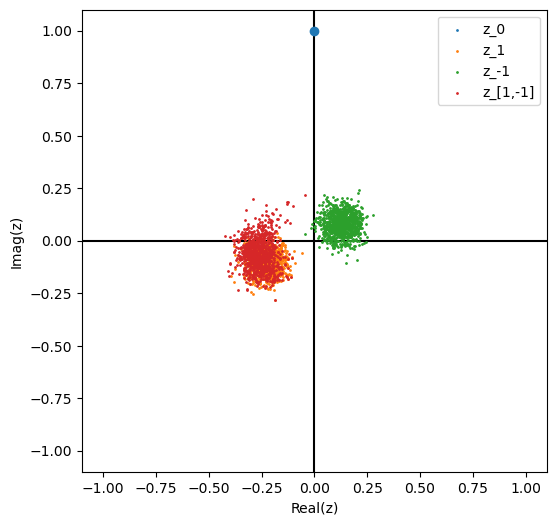

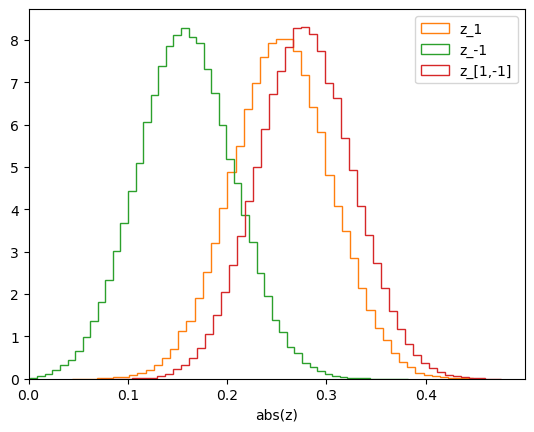

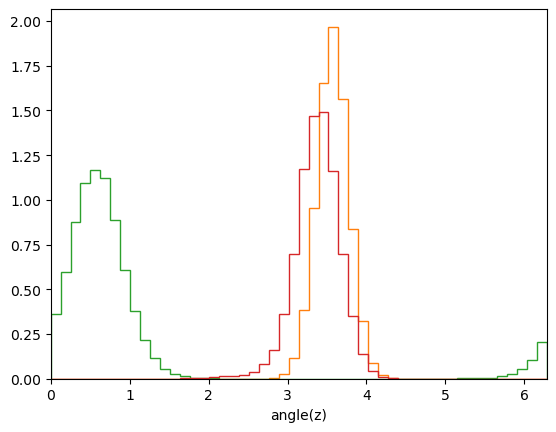

In [60]:
# SNRs and number of samples
alpha_0 = 20
alpha_1 = 5
alpha_n1 = 3
phi_0 = np.pi/2
phi_1 = np.pi/2 + 2
phi_n1 = np.pi/2 - 1
z_0 = alpha_0*np.exp(1j*phi_0)
z_1 = alpha_1*np.exp(1j*phi_1)
z_n1 = alpha_n1*np.exp(1j*phi_n1)
n = 10**5

# Generate samples
s_real_1, s_imag_1 = np.random.normal(np.real(z_1), 1, n), np.random.normal(np.imag(z_1), 1, n)
s_1 = s_real_1 + 1j*s_imag_1
s_real_n1, s_imag_n1 = np.random.normal(np.real(z_n1), 1, n), np.random.normal(np.imag(z_n1), 1, n)
s_n1 = s_real_n1 + 1j*s_imag_n1
s_amp_1n1, s_phase_1n1 = comb_harm_consistent([np.full(n, alpha_0), np.abs(s_1), np.abs(s_n1)], [np.full(n, phi_0), np.angle(s_1), np.angle(s_n1)])
s_1n1 = s_amp_1n1*np.exp(1j*(s_phase_1n1+phi_0))
s_real_1n1, s_imag_1n1 = np.real(s_1n1), np.imag(s_1n1)

# Plot samples in complex space
plt.figure(figsize=(6,6))
plt.scatter(np.real(z_0)/alpha_0, np.imag(z_0)/alpha_0, c='C0')
plt.scatter(np.real(z_0)/alpha_0, np.imag(z_0)/alpha_0, s=1, c='C0', label='z_0')
plt.scatter(s_real_1[::100]/alpha_0, s_imag_1[::100]/alpha_0, s=1, c='C1', label='z_1')
plt.scatter(s_real_n1[::100]/alpha_0, s_imag_n1[::100]/alpha_0, s=1, c='C2', label='z_-1')
plt.scatter(s_real_1n1[::100], s_imag_1n1[::100], s=1, c='C3', label='z_[1,-1]')
max_point = np.max([np.real(z_0)/alpha_0, np.imag(z_0)/alpha_0])*1.1
plt.xlim(-max_point,max_point)
plt.ylim(-max_point,max_point)
plt.axvline(0, c='k', zorder=0)
plt.axhline(0, c='k', zorder=0)
plt.xlabel('Real(z)')
plt.ylabel('Imag(z)')
plt.legend()
plt.show()

# Plot amplitude of samples (SNR)
plt.hist(np.abs(s_1)/alpha_0, bins=50, histtype='step', density=True, color='C1', label='z_1')
plt.hist(np.abs(s_n1)/alpha_0, bins=50, histtype='step', density=True, color='C2', label='z_-1')
plt.hist(np.abs(s_1n1), bins=50, histtype='step', density=True, color='C3', label='z_[1,-1]')
plt.xlim(0,)
plt.xlabel('abs(z)')
plt.legend()
plt.show()

# Plot phase of samples
plt.hist(np.angle(s_1)%(2*np.pi), bins=50, histtype='step', range=(0,2*np.pi), density=True, color='C1', label='z_1')
plt.hist(np.angle(s_n1)%(2*np.pi), bins=50, histtype='step', range=(0,2*np.pi), density=True, color='C2', label='z_-1')
plt.hist(np.angle(s_1n1)%(2*np.pi), bins=50, histtype='step', range=(0,2*np.pi), density=True, color='C3', label='z_[1,-1]')
plt.xlim(0,2*np.pi)
plt.xlabel('angle(z)')
plt.show()

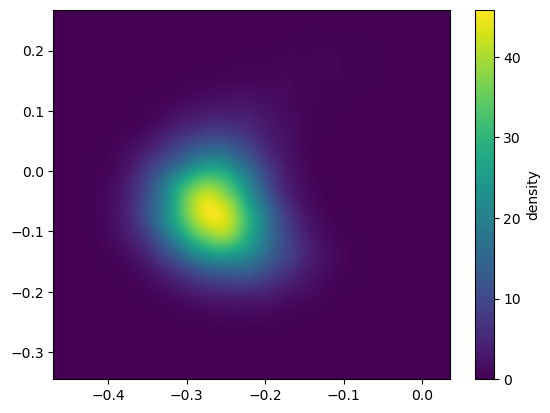

In [61]:
# Compute prior kde at points on 2d grid
kde_samples = np.array([np.real(s_1n1), np.imag(s_1n1)])
kernel = gaussian_kde(kde_samples)
kde_x, kde_y = np.mgrid[np.min(np.real(s_1n1)):np.max(np.real(s_1n1)):51j, np.min(np.imag(s_1n1)):np.max(np.imag(s_1n1)):51j]
kde_z = kernel(np.vstack([kde_x.flatten(), kde_y.flatten()])).reshape(kde_x.shape)

# Plot prior kde
x_coords = kde_x[:,0]
y_coords = kde_y[0]
dx = (x_coords[1]-x_coords[0])/2.
dy = (y_coords[1]-y_coords[0])/2.
extent = [x_coords[0]-dx, x_coords[-1]+dx, y_coords[0]-dy, y_coords[-1]+dy]
cm = plt.imshow(kde_z.T, interpolation='bicubic', cmap='viridis', extent=extent, origin='lower', aspect='auto')
plt.colorbar(cm, label='density')
# plt.scatter(kde_x, kde_y, c='r', s=1)

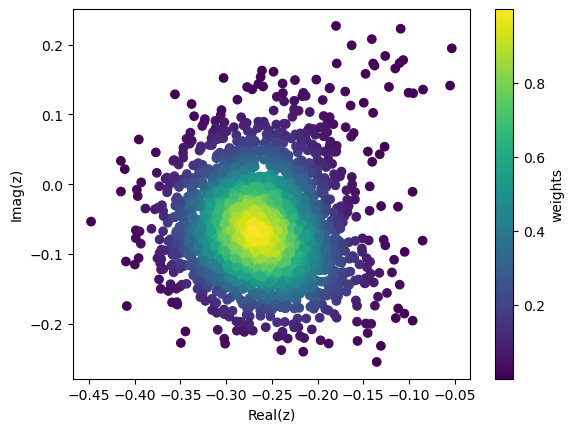

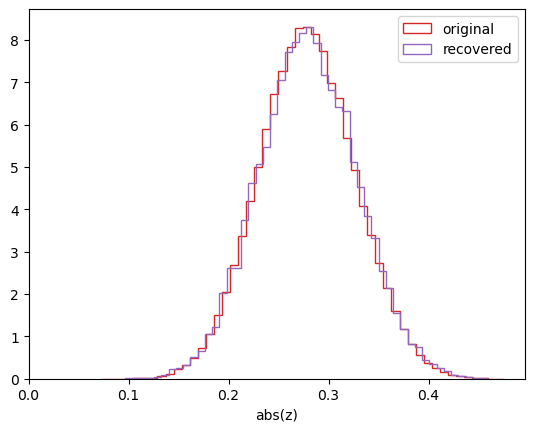

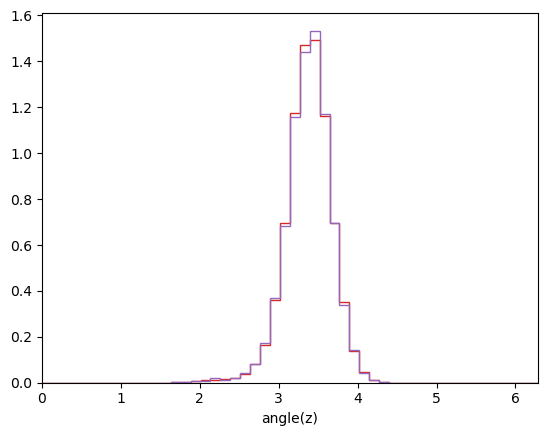

In [62]:
# Draw from resulting distribution to check against original samples for accuracy
samples_x = np.random.uniform(-0.5,0.5,10**6)
samples_y = np.random.uniform(-0.5,0.5,10**6)
weights = griddata((kde_x.flatten(), kde_y.flatten()), kde_z.flatten(), (samples_x.flatten(), samples_y.flatten()), method='linear', fill_value=0)
weights = weights/np.max(weights)
proposal = weights>=np.random.rand(len(weights))
recovered = weights[proposal]
recovered_x = samples_x[proposal]
recovered_y = samples_y[proposal]

# Recovered samples with weights as colours
plt.scatter(recovered_x[::10], recovered_y[::10], c=recovered[::10], cmap='viridis')
plt.colorbar(label='weights')
plt.xlabel('Real(z)')
plt.ylabel('Imag(z)')
plt.show()

# Compare histograms of amplitude
plt.hist(np.abs(s_1n1), bins=50, histtype='step', density=True, color='C3', label='original')
plt.hist(np.sqrt(recovered_x**2+recovered_y**2), bins=50, histtype='step', density=True, color='C4', label='recovered')
plt.xlim(0,)
plt.xlabel('abs(z)')
plt.legend()
plt.show()

# Compare histograms of phase
plt.hist(np.angle(s_1n1)%(2*np.pi), bins=50, histtype='step', range=(0,2*np.pi), density=True, color='C3', label='original')
plt.hist(np.angle(recovered_x+1j*recovered_y)%(2*np.pi), bins=50, histtype='step', range=(0,2*np.pi), density=True, color='C4', label='recovered')
plt.xlim(0,2*np.pi)
plt.xlabel('angle(z)')
plt.show()

# Functions

## Calculating samples

In [2]:
def create_map(match_grid, two_ecc_harms=True, map_len=151):
    """
    Creates arrays of eccentricity, MA, and SNR to allow for interpolation
    from any two parameters to a third.

    Parameters:
        match_grid: Object containing match data.
        two_ecc_harms: Whether to include two higher eccentric harmonics.
        map_len: Number of points in eccentricity and MA dimensions.

    Returns:
        map_e: Eccentricity mapping array.
        map_MA: MA mapping array.
        map_SNR: SNR mapping array.
    """ 

    # Get sparse mapping points
    e_vals = match_grid['metadata']['degen_params']['ecc10']
    MA_vals = match_grid['metadata']['MA_vals']
    sparse_e = np.tile(np.repeat(e_vals, len(MA_vals)),3)
    if two_ecc_harms:
        sparse_SNR = np.tile(match_grid['h1_h-1_h0_pc'].flatten(), 3)
        MA_merger = (match_grid['h1_h-1_h0_pc_phase']).flatten()%(2*np.pi)
    else:
        sparse_SNR = np.tile(match_grid['h1_h0'].flatten(), 3)
        MA_merger = (match_grid['h1_phase']-match_grid['h0_phase']).flatten()%(2*np.pi)
    sparse_MA = np.concatenate((MA_merger-2*np.pi, MA_merger, MA_merger+2*np.pi))
    
    # Get dense mapping points
    map_e = np.tile(np.linspace(np.min(e_vals), np.max(e_vals), map_len), map_len)
    map_MA = np.repeat(np.linspace(0, 2*np.pi, map_len), map_len)
    map_SNR = griddata((sparse_e, sparse_MA), sparse_SNR, (map_e, map_MA), method='linear')

    return map_e, map_MA, map_SNR

In [18]:
def SNR_weights(harm_SNRs, prior_MA, prior_SNR, two_ecc_harms=True):
    """
    Get weights of each prior sample based on harmonic SNR information.

    Parameters:
        harm_SNRs: Dicitonary of complex SNRs of eccentric harmonics.
        prior_e: Prior samples on eccentricity.
        prior_MA: Prior samples on MA.
        two_ecc_harms: Whether to include two higher eccentric harmonics.

    Returns:
        weights: Weight of each prior sample.
    """ 

    # Convert prior samples to x and y coordinates
    prior_x = np.real(prior_SNR*np.exp(1j*prior_MA))
    prior_y = np.imag(prior_SNR*np.exp(1j*prior_MA))

    if two_ecc_harms:

        # Draw samples on combined complex SNR
        n = 10**5
        s_1_x, s_1_y = np.random.normal(np.real(harm_SNRs[1]), 1, n), np.random.normal(np.imag(harm_SNRs[1]), 1, n)
        s_1 = s_1_x + 1j*s_1_y
        s_n1_x, s_n1_y = np.random.normal(np.real(harm_SNRs[-1]), 1, n), np.random.normal(np.imag(harm_SNRs[-1]), 1, n)
        s_n1 = s_n1_x + 1j*s_n1_y
        s_1n1_SNR, s_1n1_MA = comb_harm_consistent([np.full(n, np.abs(harm_SNRs[0])), np.abs(s_1), np.abs(s_n1)],
                                                   [np.full(n, np.angle(harm_SNRs[0])), np.angle(s_1), np.angle(s_n1)])
        s_1n1 = s_1n1_SNR*np.exp(1j*s_1n1_MA)
        s_1n1_x, s_1n1_y = np.real(s_1n1), np.imag(s_1n1)

        # Compute combined kde at points on 2d grid
        kde_samples = np.array([s_1n1_x, s_1n1_y])
        kernel = gaussian_kde(kde_samples)

        # Draw weights from interpolated kde
        kde_x, kde_y = np.mgrid[np.min(s_1n1_x):np.max(s_1n1_x):51j, np.min(s_1n1_y):np.max(s_1n1_y):51j]
        kde_z = kernel(np.vstack([kde_x.flatten(), kde_y.flatten()])).reshape(kde_x.shape)
        weights = griddata((kde_x.flatten(), kde_y.flatten()), kde_z.flatten(), (prior_x.flatten(), prior_y.flatten()), method='linear', fill_value=0)
        
    else:

        # If only first higher harmonic, weights drawn from gaussian pdf
        h1_MA = np.angle(harm_SNRs[1]) - np.angle(harm_SNRs[0])
        h1_x = np.real(np.abs(harm_SNRs[1])*np.exp(1j*h1_MA))
        h1_y = np.imag(np.abs(harm_SNRs[1])*np.exp(1j*h1_MA))
        rv = multivariate_normal(mean=[h1_x, h1_y], cov=[1,1])
        weights = rv.pdf(np.array([prior_x*np.abs(harm_SNRs[0]), prior_y*np.abs(harm_SNRs[0])]).T)

    # Normalise
    weights /= np.max(weights)

    return weights
        

In [4]:
def get_param_samples(harm_SNRs, prior_e, prior_MA, map_e, map_MA, map_SNR, two_ecc_harms=True):
    """
    Get parameter samples by combining prior with harmonic SNR information.

    Parameters:
        harm_SNRs: Dicitonary of complex SNRs of eccentric harmonics.
        prior_e: Prior samples on eccentricity.
        prior_MA: Prior samples on MA.
        map_e: Eccentricity mapping array.
        map_MA: MA mapping array.
        map_SNR: SNR mapping array.
        two_ecc_harms: Whether to include two higher eccentric harmonics.

    Returns:
        samples_e: Samples on eccentricity.
        samples_MA: Samples on MA.
        samples_SNR: Samples on SNR.
    """ 

    # Convert prior samples to SNR space
    prior_SNR = griddata((map_e, map_MA), map_SNR, (prior_e, prior_MA), method='linear')

    # Get weights based on SNR information
    weights = SNR_weights(harm_SNRs, prior_MA, prior_SNR, two_ecc_harms=two_ecc_harms)
    proposals = weights>np.random.rand(len(weights))
    samples_e, samples_MA, samples_SNR = prior_e[proposals], prior_MA[proposals], prior_SNR[proposals]

    return samples_e, samples_MA, samples_SNR

## Plotting

In [40]:
def plot_SNR2ecc(match_grid, samples_e, samples_SNR, two_ecc_harms=True):

    # Key for matches
    if two_ecc_harms:
        match_key = 'h1_h-1_h0_pc'
    else:
        match_key = 'h1_h0'

    # Useful parameters
    e_vals = match_grid['metadata']['degen_params']['ecc10']
    max_line = np.max(match_grid[match_key], axis=1)
    min_line = np.min(match_grid[match_key], axis=1)

    # Compute kde of ecc-SNR at points on 2d grid
    kde_samples = np.array([samples_e, samples_SNR])
    kernel = gaussian_kde(kde_samples)
    kde_x, kde_y = np.mgrid[np.min(samples_e):np.max(samples_e):101j, np.min(samples_SNR):np.max(samples_SNR):101j]
    max_interp = interp1d(e_vals, max_line)
    min_interp = interp1d(e_vals, min_line)
    inside_lines = (kde_y.flatten() <= max_interp(kde_x.flatten())*1.1)*(kde_y.flatten() >= min_interp(kde_x.flatten())*0.9)
    kde_z = np.zeros(len(kde_x.flatten()))
    kde_z[inside_lines] = kernel(np.vstack([kde_x.flatten()[inside_lines], kde_y.flatten()[inside_lines]]))
    kde_z = kde_z.reshape(kde_x.shape)

    # Calculate contour levels for 90% confidence intervals
    t = np.linspace(0, np.max(kde_z), 1000)
    integral = ((kde_z >= t[:, None, None]) * kde_z).sum(axis=(1,2))
    integral /= np.max(integral)
    f = interp1d(integral, t)
    t_contours = f([0.9])

    # Calculate color map with varying alpha
    c_rgba = mcolors.to_rgba('C2')
    cmap_rgbas = [c_rgba[:3]+(alpha,) for alpha in np.linspace(0,1,101)]
    cmap = mcolors.ListedColormap(cmap_rgbas)

    # Plot density and 90% contour
    x_coords = kde_x[:,0]
    y_coords = kde_y[0]
    dx = (x_coords[1]-x_coords[0])/2.
    dy = (y_coords[1]-y_coords[0])/2.
    extent = [x_coords[0]-dx, x_coords[-1]+dx, y_coords[0]-dy, y_coords[-1]+dy]
    plt.imshow(np.sqrt(kde_z.T), interpolation='bicubic', cmap=cmap, extent=extent, origin='lower', aspect='auto',zorder=1/4)
    contour_c = tuple(p*0.5 for p in c_rgba[:3]) +  (c_rgba[3],)
    plt.contour(kde_x, kde_y, kde_z, levels=t_contours, colors=[contour_c], linewidths=1, linestyles='dashed', zorder=2/4)

    # Plot min/max lines
    plt.fill_between(e_vals, np.min(min_line), min_line, color='w', zorder=3/4)
    plt.fill_between(e_vals, max_line, np.max(max_line), color='w', zorder=3/4)
    plt.plot(e_vals, max_line, c='k', lw=1, alpha=0.7, zorder=4/4)
    plt.plot(e_vals, min_line, c='k', lw=1, alpha=0.7, zorder=4/4)

    plt.xlabel('e_10')
    plt.xlim(0,0.4)
    plt.ylabel('SNR fraction')
    plt.ylim(0,max_interp(0.4))

# Testing functions

In [7]:
with open(os.path.join('grid_data_4d', 'dataslot_7', 'all_matches'), 'rb') as fp:
    grid_data_7 = pickle.load(fp)

In [47]:
harm_SNRs = {0: 20*np.exp(1j*1.98),
             1: 4*np.exp(1j*1.98),
             -1: 2*np.exp(1j*1.98)}
prior_e = np.random.rand(10**6)*0.5
prior_MA = np.random.rand(10**6)*2*np.pi
map_e, map_MA, map_SNR = create_map(grid_data_7)
samples_e, samples_MA, samples_SNR = get_param_samples(harm_SNRs, prior_e, prior_MA, map_e, map_MA, map_SNR)

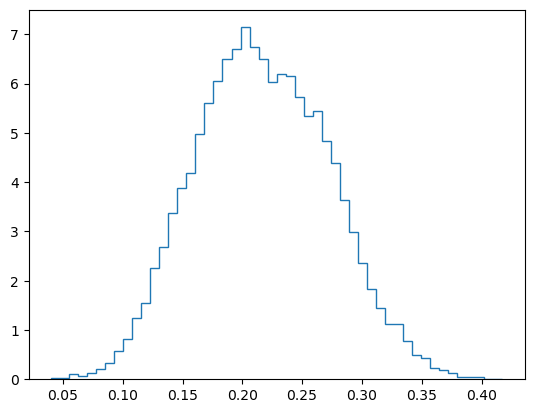

In [48]:
_ = plt.hist(samples_e, bins=50, histtype='step', density=True)

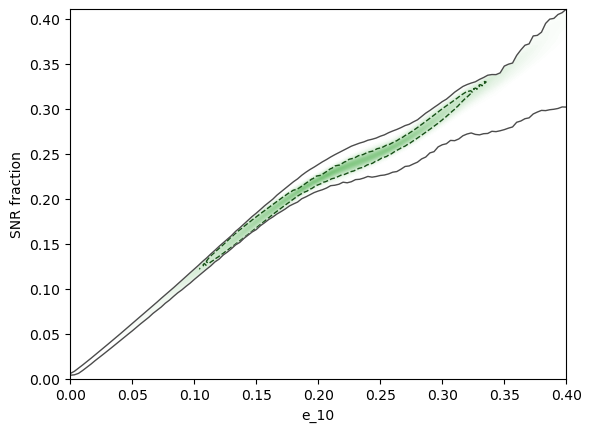

In [49]:
plot_SNR2ecc(grid_data_7, samples_e, samples_SNR)